In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os, sys

In [3]:
import pandas as pd

In [4]:
sys.path.append('..')

from pyMultiOmics.constants import GENES, PROTEINS, COMPOUNDS
from pyMultiOmics.base import SingleOmicsData, MultiOmicsData
from pyMultiOmics.common import set_log_level_info, set_log_level_debug, download_file, extract_zip_file
from pyMultiOmics.mofax import MofaPipeline

2022-03-24 14:47:45.330 | WARNING  | pyMultiOmics.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2022-03-24 14:47:45.330 | WARNING  | pyMultiOmics.reactome:get_neo4j_driver:19 - Using a default neo4j username or password: neo4j
2022-03-24 14:47:45.331 | INFO     | pyMultiOmics.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


In [5]:
import mofax as mfx

In [6]:
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.dpi'] = 200

In [7]:
# from mofapy2.run.entry_point import entry_point
# import pandas as pd
# import io
# import requests # to download the online data
# import numpy as np
# import matplotlib.pyplot as plt
# import h5py

# import seaborn as sns
# from matplotlib import rcParams
# rcParams['figure.dpi'] = 200

# from typing import Union

### Load the multi-omics COVID-19 data from [1]

[1] [Overmyer, Katherine A., et al. "Large-scale multi-omic analysis of COVID-19 severity." Cell systems 12.1 (2021): 23-40.](https://www.sciencedirect.com/science/article/pii/S2405471220303719)

In [8]:
url = 'https://github.com/glasgowcompbio/pyMultiOmics-data/raw/main/covid19_multiomics_data.zip'
out_file = download_file(url)
extract_zip_file(out_file)

2022-03-24 14:47:47.055 | INFO     | pyMultiOmics.common:download_file:59 - Downloading covid19_multiomics_data.zip
2.36kKB [00:00, 12.1kKB/s]                                                                                              
2022-03-24 14:47:47.297 | INFO     | pyMultiOmics.common:extract_zip_file:71 - Extracting covid19_multiomics_data.zip
100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 185.08it/s]
2022-03-24 14:47:47.379 | INFO     | pyMultiOmics.common:extract_zip_file:77 - Deleting covid19_multiomics_data.zip


In [9]:
DATA_FOLDER = os.path.abspath(os.path.join('covid19_multiomics_data'))
DATA_FOLDER

'/Users/joewandy/Work/git/pyMultiOmics/notebooks/covid19_multiomics_data'

### Read the individual dataframes

In [10]:
transcript_df = pd.read_csv(os.path.join(DATA_FOLDER, 'covid_genes_include_p.csv'), index_col='Identifier')
transcript_design = pd.read_csv(os.path.join(DATA_FOLDER, 'covid_genes_design.csv'), index_col='sample')

In [11]:
protein_df = pd.read_csv(os.path.join(DATA_FOLDER, 'covid_protein_include_p.csv'), index_col='Identifier')
protein_design = pd.read_csv(os.path.join(DATA_FOLDER, 'covid_protein_design.csv'), index_col='sample')

In [12]:
compound_df = pd.read_csv(os.path.join(DATA_FOLDER, 'covid_compounds_include_p.csv'), index_col='Identifier')
compound_design = pd.read_csv(os.path.join(DATA_FOLDER, 'covid_compounds_design.csv'), index_col='sample')

### Create single omics data container objects

Some data cleaning is done upon loading in `SingleOmicsData`:
- Duplicate values are removed from the rows and columns
- Duplicate sample names are removed
- Measurements with missing metadata are removed
- Metadata with missing measurements are removed too

In [13]:
transcript_data = SingleOmicsData(GENES, transcript_df, transcript_design)
transcript_data

2022-03-24 14:47:47.738 | WARNING  | pyMultiOmics.base:_keep_common_samples:126 - Dropped 4 columns from sample metadata due to missing measurements


genes data with (13028, 125) measurements

In [14]:
protein_data = SingleOmicsData(PROTEINS, protein_df, protein_design)
protein_data

proteins data with (1499, 129) measurements

In [15]:
compound_data = SingleOmicsData(COMPOUNDS, compound_df, compound_design)
compound_data

compounds data with (46, 129) measurements

In [16]:
publication = 'Overmyer, Katherine A., et al. "Large-scale multi-omic analysis of COVID-19 severity." Cell systems 12.1 (2021): 23-40.'
url = 'https://www.sciencedirect.com/science/article/pii/S2405471220303719'

In [17]:
mo = MultiOmicsData(publication=publication, url=url)
mo.add_data([transcript_data, protein_data, compound_data])
mo

Multi-omics data container
- publication: Overmyer, Katherine A., et al. "Large-scale multi-omic analysis of COVID-19 severity." Cell systems 12.1 (2021): 23-40.
- URL: https://www.sciencedirect.com/science/article/pii/S2405471220303719
- Views: 3 modalities
	 - genes data with (13028, 125) measurements
	 - proteins data with (1499, 129) measurements
	 - compounds data with (46, 129) measurements

### Run MOFA+

In [18]:
mo.to_mofa()

,feature,sample,value,view,group
0,ENSG00000121410,sample_1,4.500000,genes,covid
1,ENSG00000175899,sample_1,3.700000,genes,covid
2,ENSG00000094914,sample_1,8.700000,genes,covid
3,ENSG00000081760,sample_1,7.400000,genes,covid
4,ENSG00000103591,sample_1,9.800000,genes,covid
...,...,...,...,...,...
5929,C00328,sample_129,17.797765,compounds,non_covid
5930,C00078,sample_129,20.894226,compounds,non_covid
5931,C01530,sample_129,19.733793,compounds,non_covid
5932,C02067,sample_129,20.978160,compounds,non_covid


In [19]:
file_path = DATA_FOLDER + '/mofa_data.hdf5'
file_path

'/Users/joewandy/Work/git/pyMultiOmics/notebooks/covid19_multiomics_data/mofa_data.hdf5'

In [20]:
m = MofaPipeline(mo, file_path)
m.set_data()
m.training()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


Loaded group='covid' view='compounds' with N=102 samples and D=46 features...
Loaded group='covid' view='genes' with N=102 samples and D=13028 features...
Loaded group='covid' view='proteins' with N=102 samples and D=1499 features...
Loaded group='non_covid' view='compounds' with N=27 samples and D=46 features...
Loaded group='non_covid' view='genes' with N=23 samples and D=13

In [21]:
m.save_model()

Saving model in /Users/joewandy/Work/git/pyMultiOmics/notebooks/covid19_multiomics_data/mofa_data.hdf5...


In [22]:
m.build_mofa()

## Demonstration of plotting features in mofax

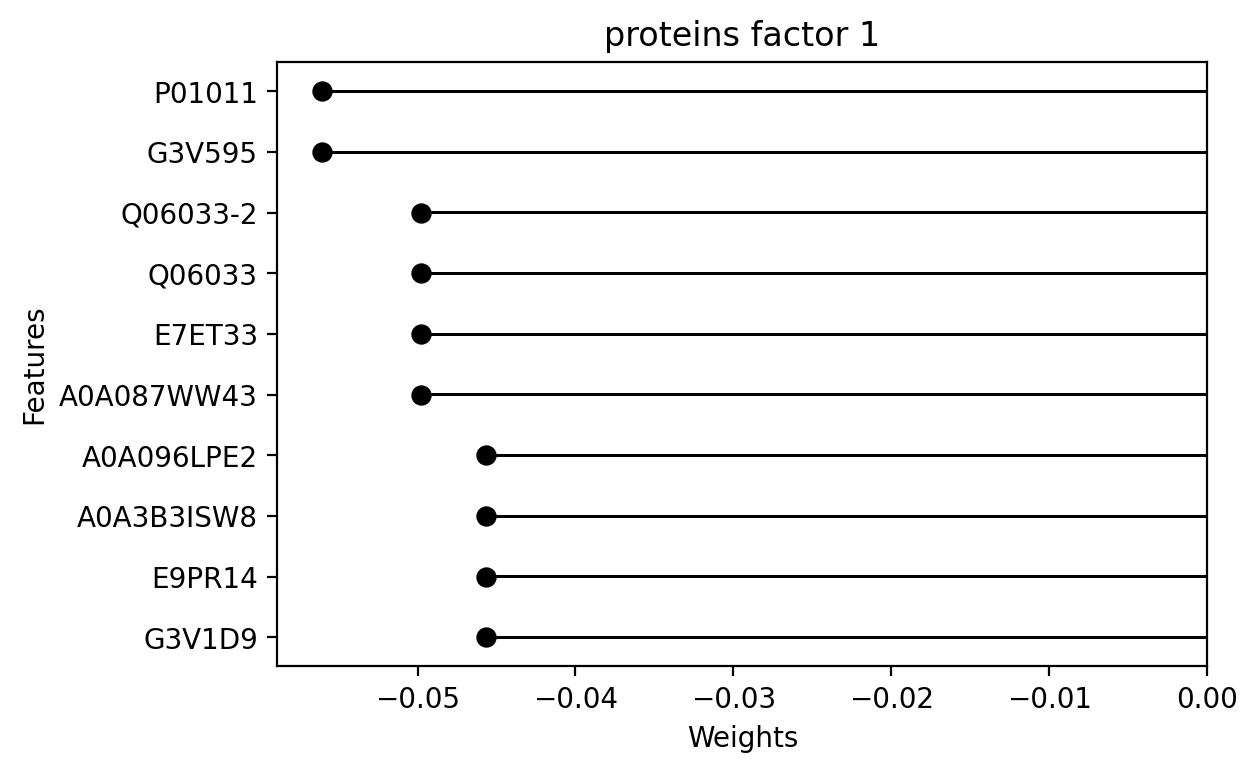

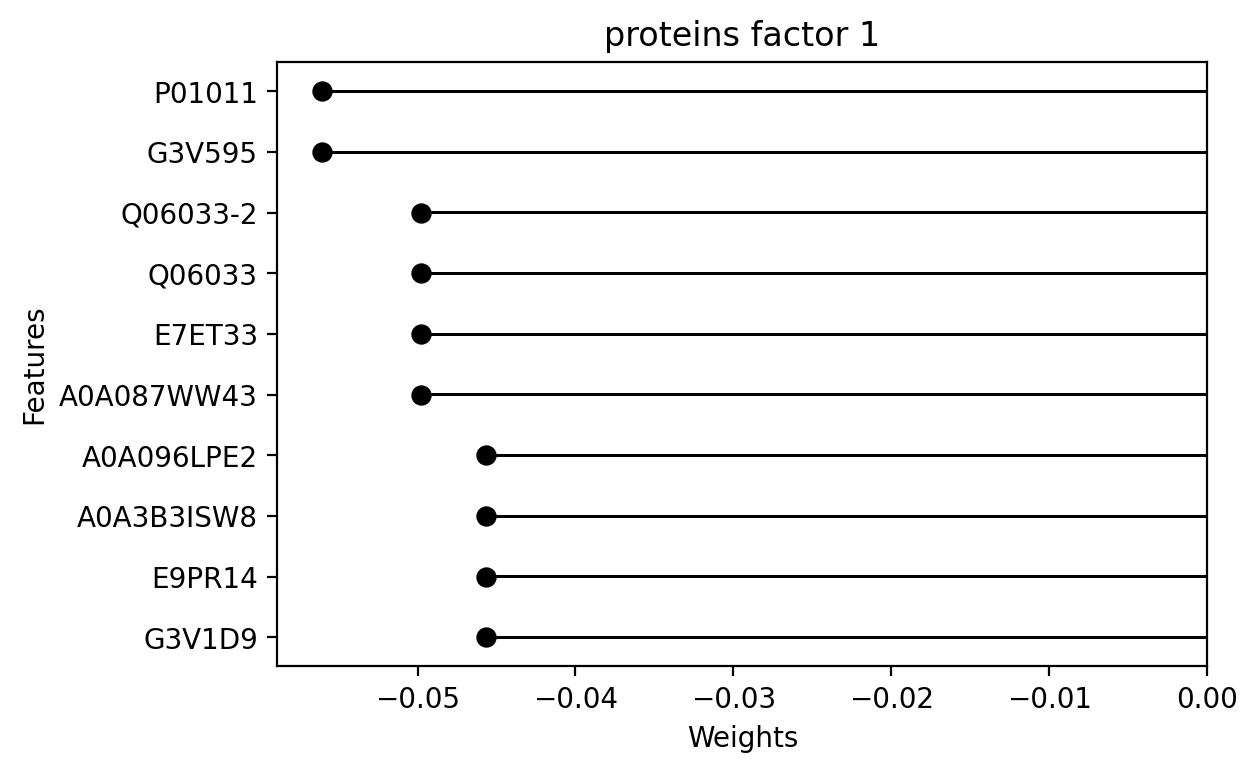

In [23]:
m.plot_top_features(factors = 0, views = 'proteins', n_features = 10)

<AxesSubplot:>

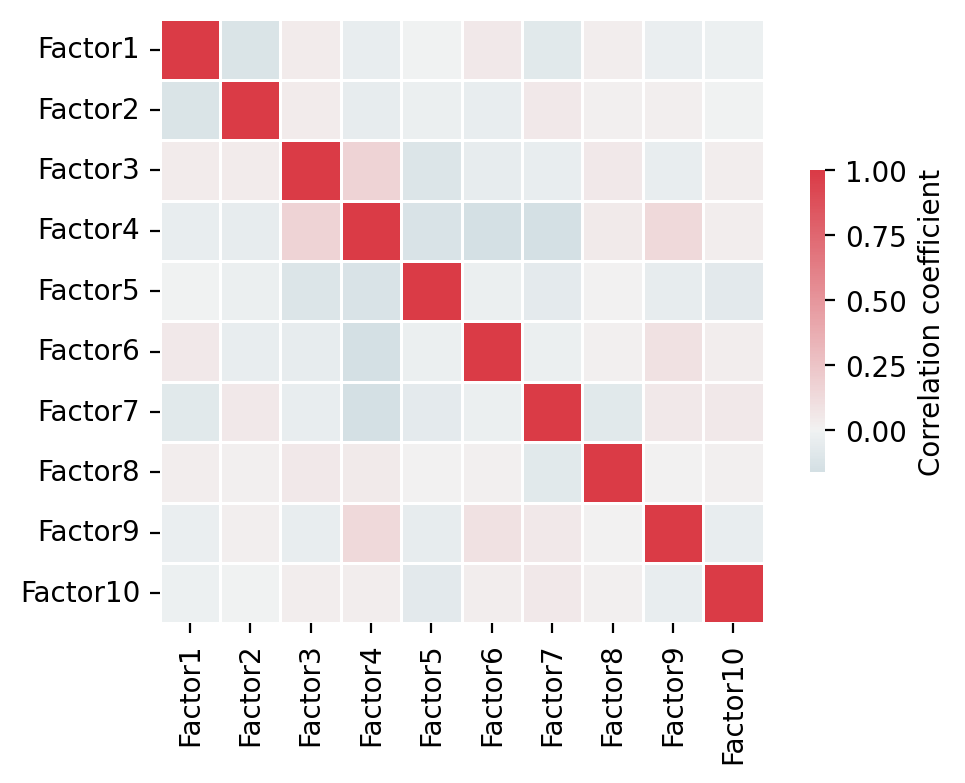

In [24]:
mfx.plot_factors_correlation(m.mofa)

<AxesSubplot:>

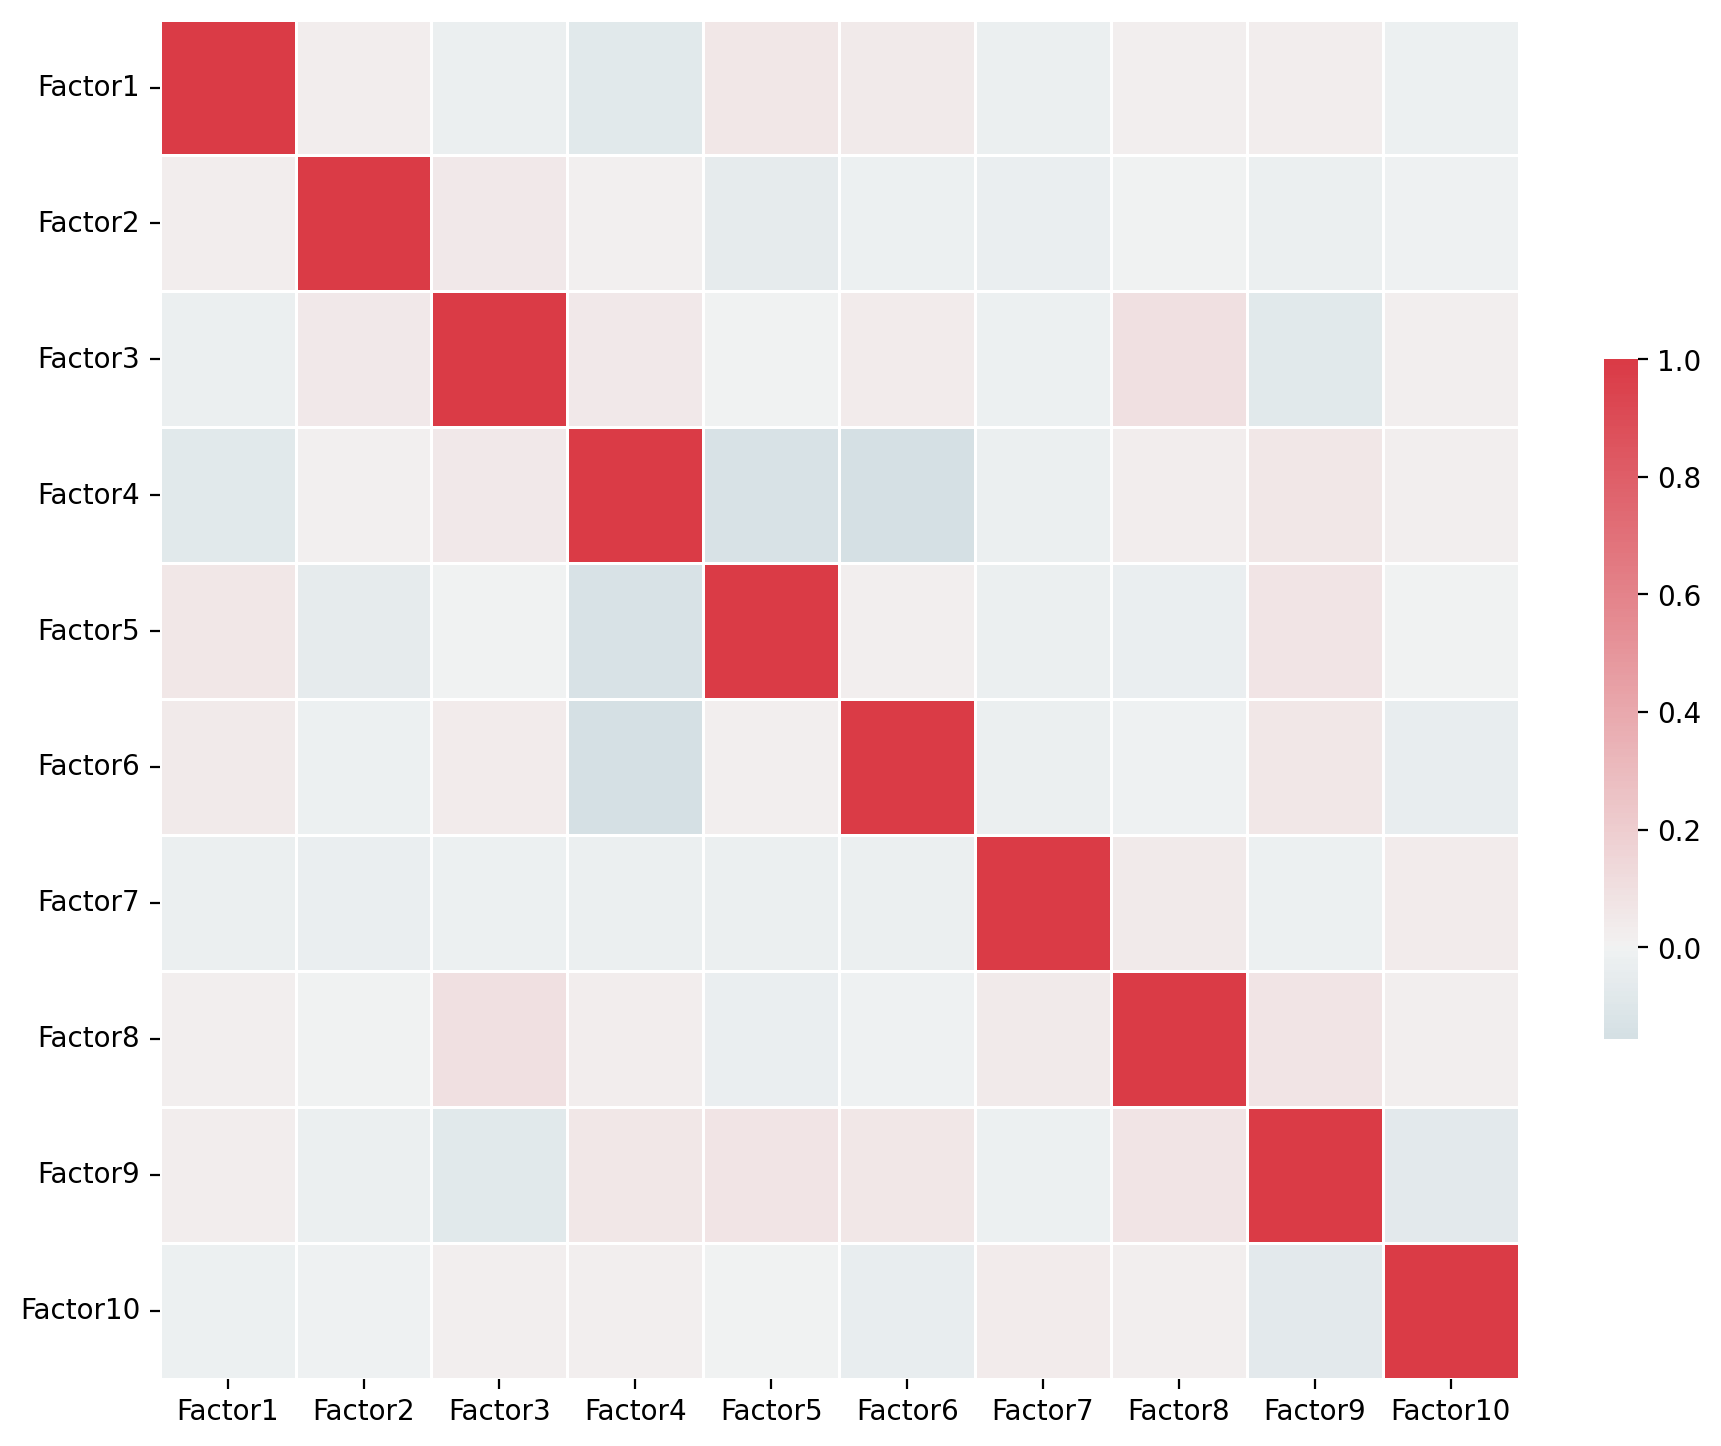

In [25]:
mfx.plot_weights_correlation(m.mofa)

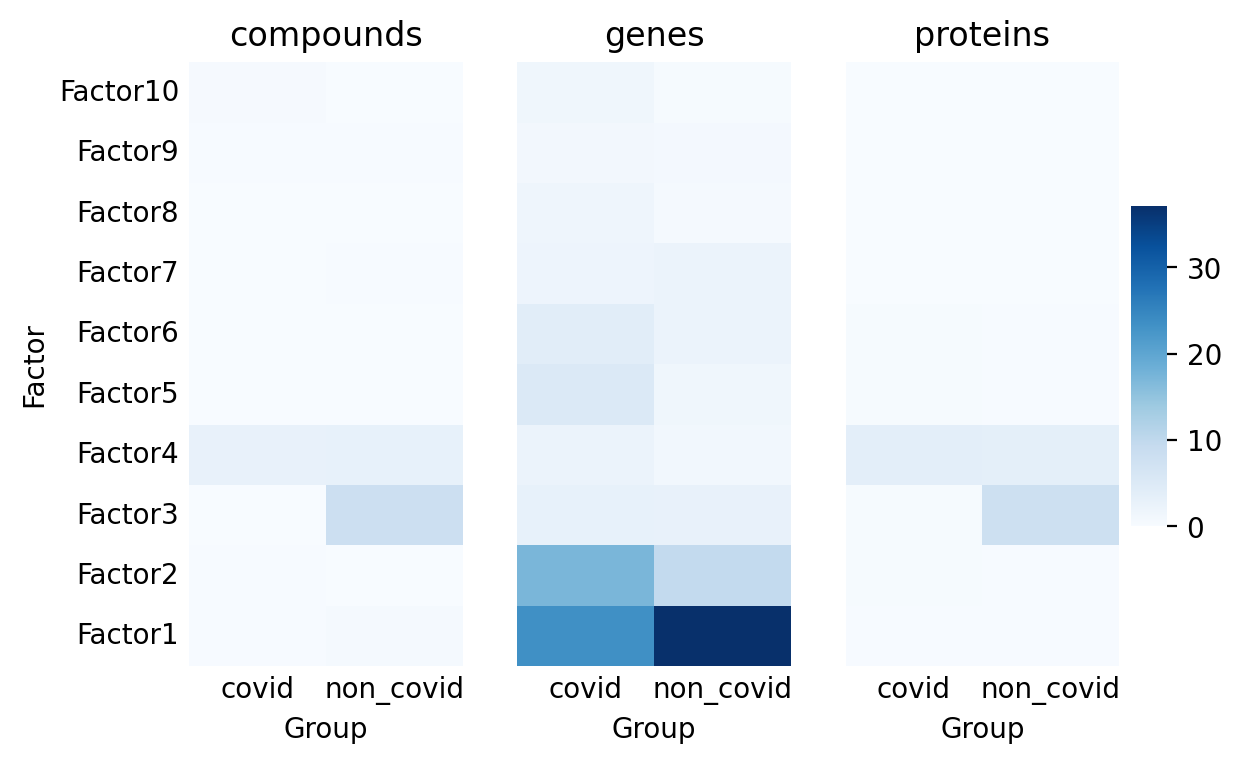

In [26]:
mfx.plot_r2(m.mofa)

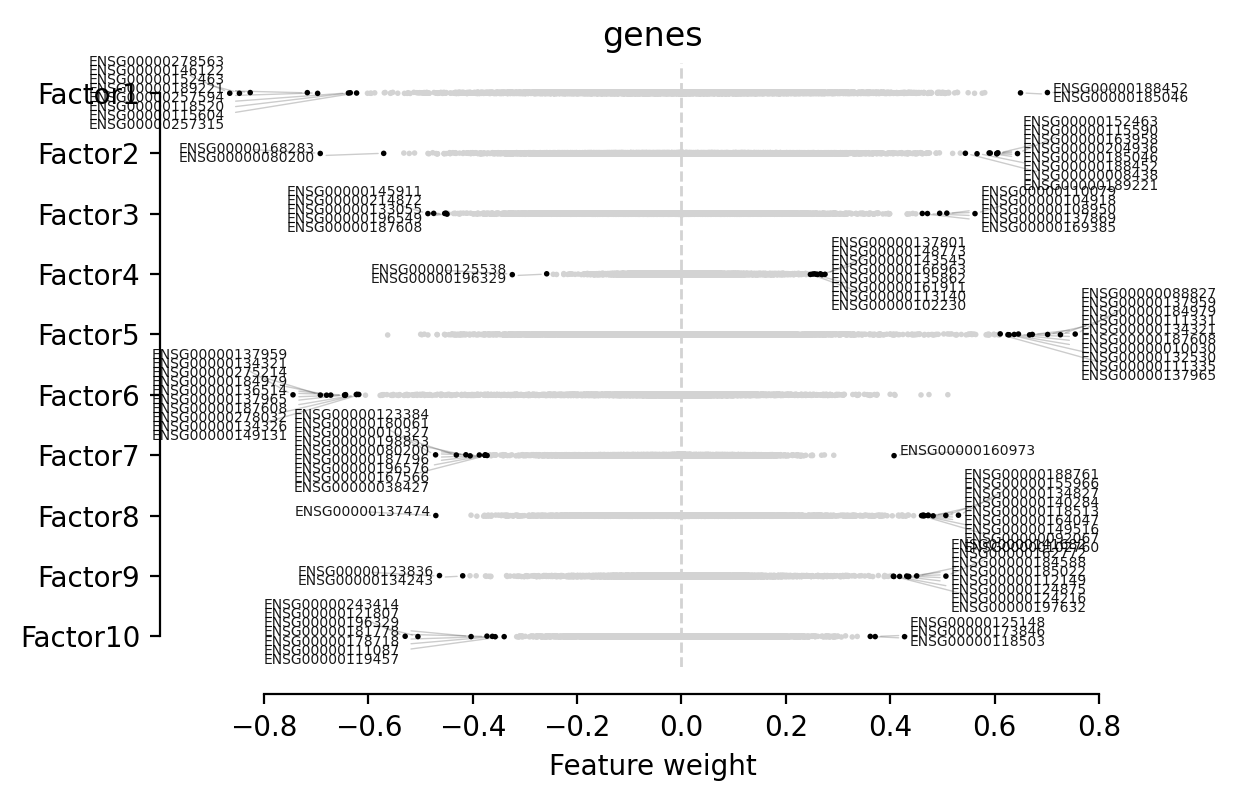

In [27]:
ax = mfx.plot_weights(m.mofa, factor=1, views = 'genes', n_features=10,
                      y_repel_coef=0.04, x_rank_offset=-150)

In [28]:
df = m.mofa.get_top_features(views = 'genes', factors = 1, n_features = 10,df = True)
df

,index,feature,factor,value,value_abs,view
0,1153,ENSG00000168283,Factor2,-0.691943,0.691943,genes
1,7404,ENSG00000152463,Factor2,0.643829,0.643829,genes
2,5070,ENSG00000115590,Factor2,0.606326,0.606326,genes
3,12425,ENSG00000163958,Factor2,0.604256,0.604256,genes
4,1783,ENSG00000204936,Factor2,0.604149,0.604149,genes
5,505,ENSG00000185046,Factor2,0.591682,0.591682,genes
6,2043,ENSG00000188452,Factor2,0.589510,0.589510,genes
7,2543,ENSG00000080200,Factor2,-0.570431,0.570431,genes
8,7811,ENSG00000008438,Factor2,0.566319,0.566319,genes
9,6035,ENSG00000189221,Factor2,0.543974,0.543974,genes


<AxesSubplot:title={'center':'group'}, xlabel='Factor1', ylabel='Factor2'>

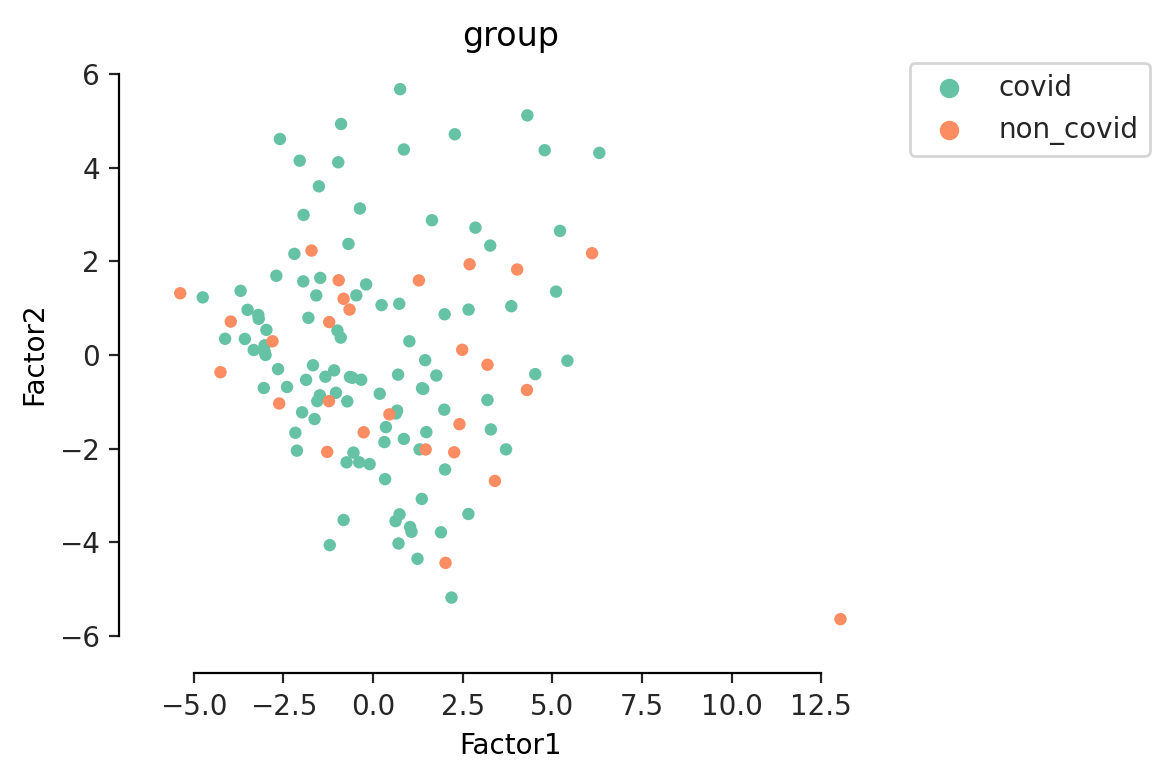

In [29]:
mfx.plot_factors(m.mofa)

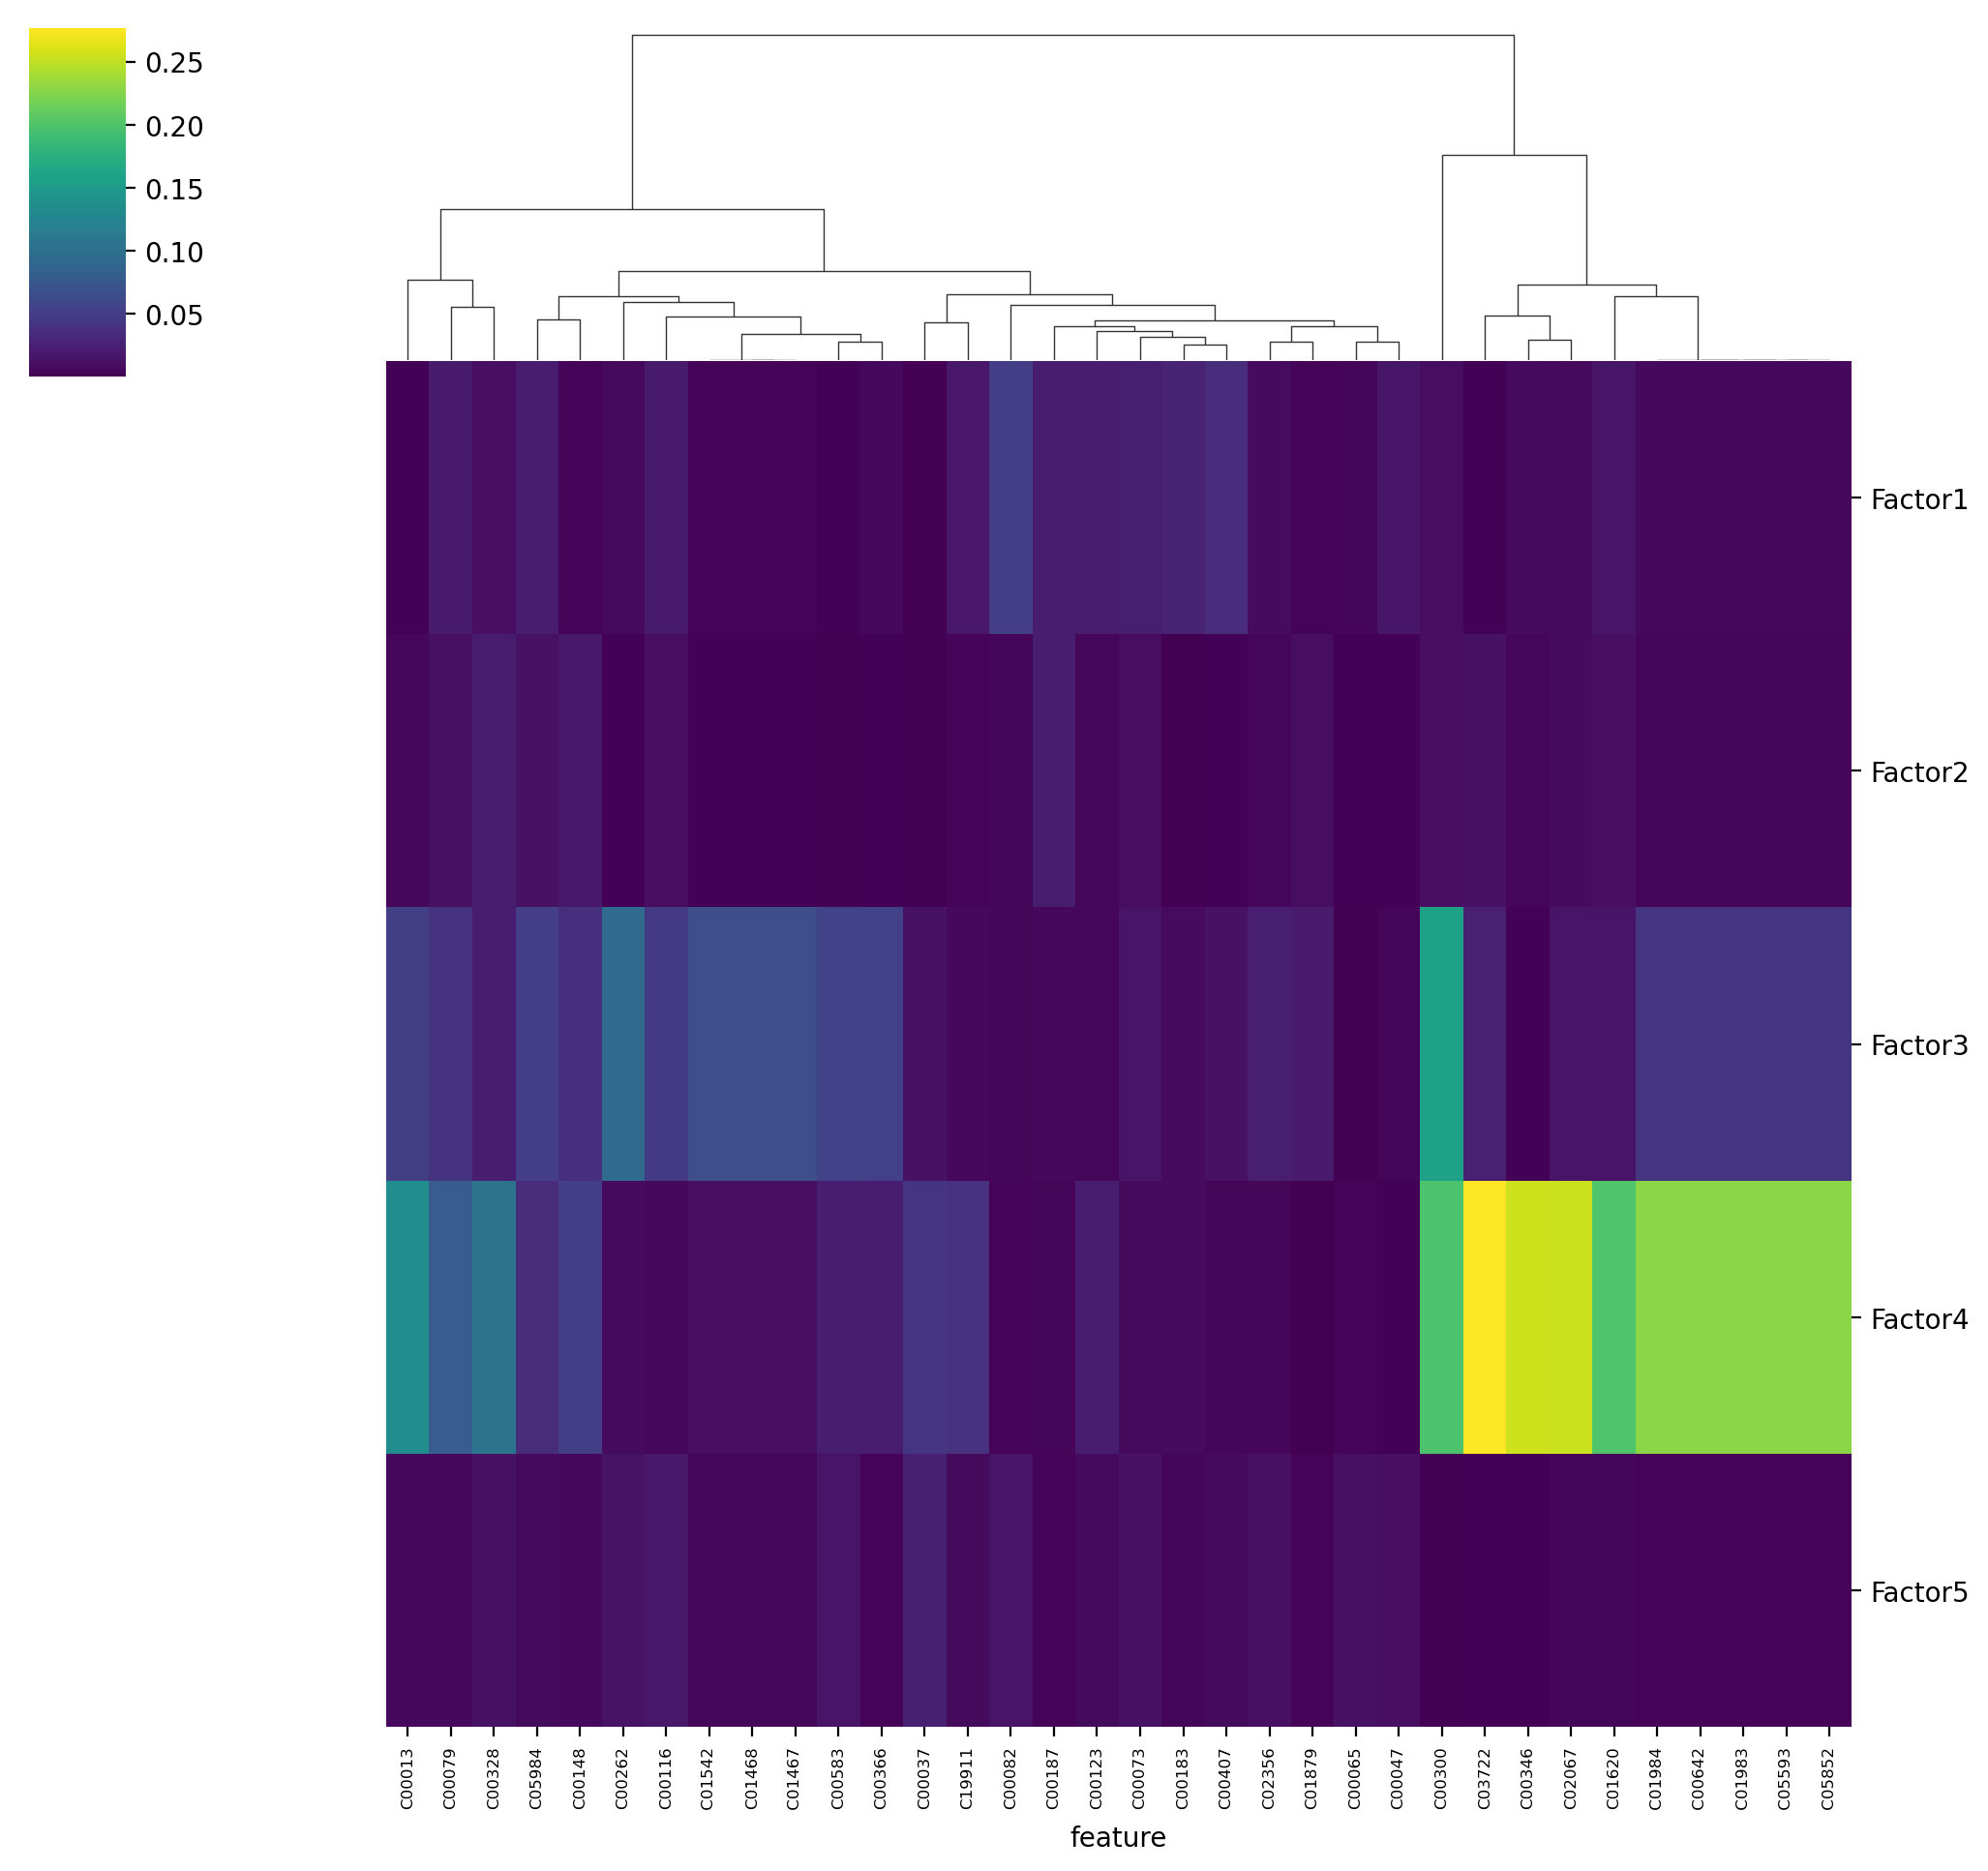

In [30]:
mfx.plot_weights_heatmap(m.mofa, n_features=10, 
                         factors=range(0, 5), 
                         xticklabels_size=6, w_abs=True, 
                         cmap="viridis", cluster_factors=False)

<AxesSubplot:xlabel='Feature rank', ylabel='Factor1 weight'>

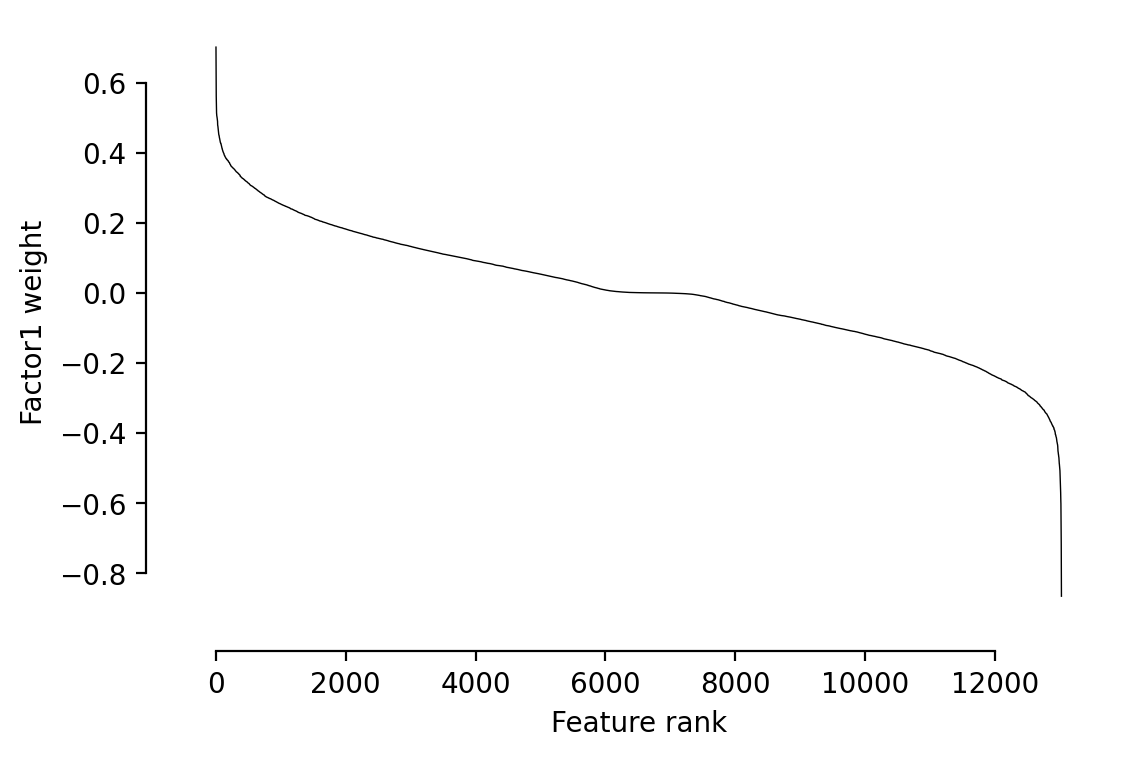

In [31]:
mfx.plot_weights_ranked(m.mofa, factor="Factor1",  view='genes', n_features = 1)

<AxesSubplot:title={'center':'group'}, xlabel='factor', ylabel='value'>

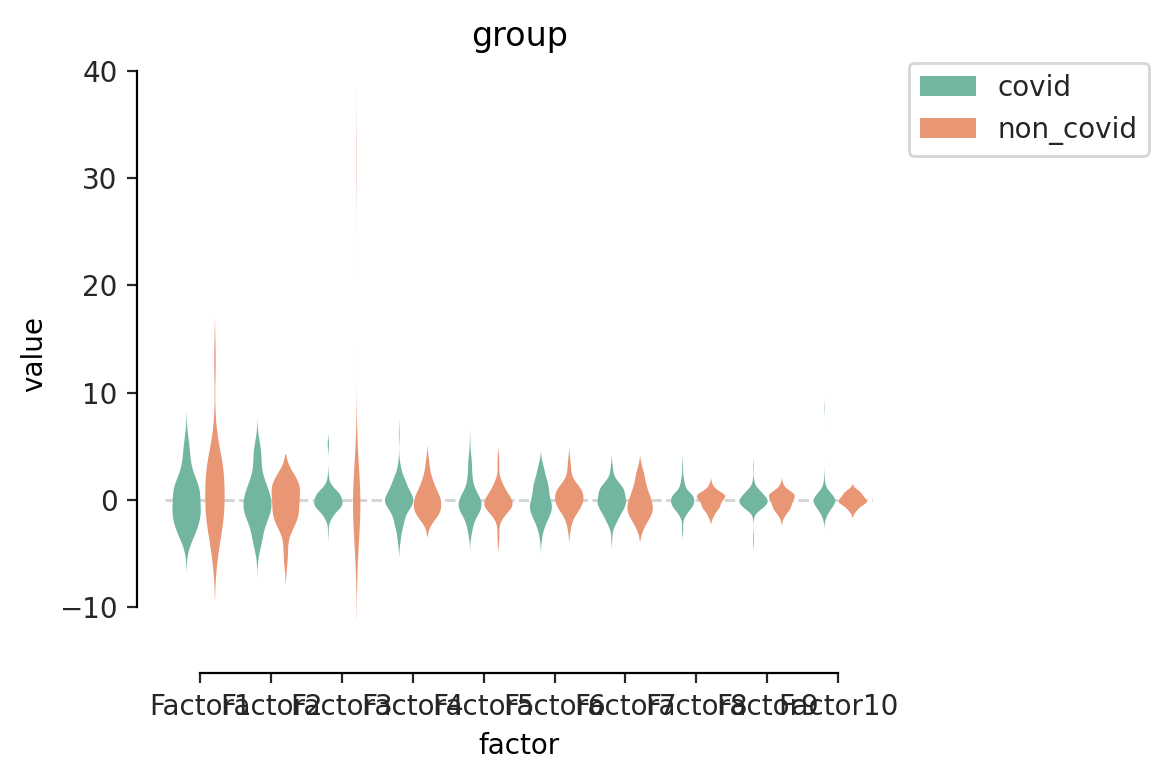

In [32]:
mfx.plot_factors_violin(m.mofa)